# **Modeling the mind of a predator: Interactive cognitive maps support flexible avoidance of dynamic threats**

### Toby Wise, Caroline J Charpentier, Peter Dayan & Dean Mobbs

#### Analysis notebook 6: MCTS Parameter estimation through simulation-based inference

> **_NOTE:_**  This notebook uses tools for simulation-based inference available in [this package](https://github.com/tobywise/simulation_based_inference) and evaluation plots available in [this package](https://github.com/tobywise/model-fit-utils), both of which are currently under development.

In [2]:
from simulation_based_inference.npe import NPEModel
from model_fit_tools.plotting import plot_recovery, plot_pp, plot_recovery_matrix
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib
import bambi
import arviz as az
from scipy.stats import ttest_ind
matplotlib.style.use('style.mplstyle')
matplotlib.rcParams['font.weight'] = 'normal'
pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams["font.family"] = "Heebo"

## Load simulated data

This data is generated using the `run_MCTS_simulations.py` script in the `code` directory.


In [3]:
simulations_A1 = np.load('data/SBI_simulations/experiment-3/condition-A1/y_data.npy', allow_pickle=True).astype(float)
parameters_A1 = np.load('data/SBI_simulations/experiment-3/condition-A1/x_data.npy', allow_pickle=True).astype(float)
simulations_A1 = simulations_A1.reshape(simulations_A1.shape[0], 1, -1)[:20000, ...]
parameters_A1 = parameters_A1[:20000, ...]
simulations_A1.shape

(20000, 1, 80)

### Split data into training and test sets

We only need a small percentage for testing, so we use 99% for training.

In [4]:
train_prop = 0.99
train_size = int(train_prop * simulations_A1.shape[0])

train_simulations_A1 = simulations_A1[:train_size]
train_parameters_A1 = parameters_A1[:train_size]

test_simulations_A1 = simulations_A1[train_size:]
test_parameters_A1 = parameters_A1[train_size:]

print(train_simulations_A1.shape, test_simulations_A1.shape)
print(train_parameters_A1.shape, test_parameters_A1.shape)

(19800, 1, 80) (200, 1, 80)
(19800, 2) (200, 2)


## Fit the model

This trains the model to predict parameter values from the simulated data.

In [5]:
npe = NPEModel(choice_format='numerical')
npe.fit(train_simulations_A1, train_parameters_A1)

2023-02-28 16:59:47.995378: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 16:59:48.587088: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-28 16:59:48.831166: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-28 16:59:52.467790: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

 Neural network successfully converged after 54 epochs.

## Sample from the posterior

This uses the test data reserved for assessing the model's performance.

In [6]:
sampled_params_A1 = npe.sample(test_simulations_A1, n_samples=2000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 84.26it/s]


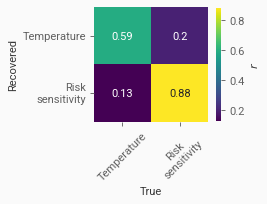

In [28]:
plot_recovery_matrix(
    test_parameters_A1.squeeze().astype(float),
    sampled_params_A1,
    param_names=["Temperature", "Risk\nsensitivity"],
    scale=1.1,
    xtick_rotation=45,
    colorbar_scale=0.78,
    save_path="figures/",
    save_fname="exp-3_cond-A1_recovery.svg",
)


## Get real data

### Load in subjects' responses

In [7]:
response_dfs = []

output_dir = 'data/'
experiment = 'experiment-3'

data_dfs = {'response_data': response_dfs}

for data_type, df_list in data_dfs.items():
    
    data_type_dir = os.path.join(output_dir, data_type, experiment)
    
    conditions = os.listdir(data_type_dir)
    
    for c in conditions:
        for i in os.listdir(os.path.join(data_type_dir, c)):
            if '.csv' in i and not 'SIMULATED' in i:
                df = pd.read_csv(os.path.join(data_type_dir, c, i))
                df_list.append(df)

response_df = pd.concat(response_dfs)

### Convert to a format that can be used by the model

In [8]:
# Select condition A1
response_df_A1 = response_df[response_df['condition'] == 'A1'].copy()

# Initialise array to store all moves, with -1 as a placeholder for missing moves
all_moves_A1 = np.ones((response_df_A1['subjectID'].nunique(), 5, 16)) * -1

for n_sub, sub in enumerate(response_df_A1['subjectID'].unique()):

    for n_env, env in enumerate(response_df_A1['env'].unique()[1:]):

        # Get data for this subject and environment
        env_df = response_df_A1[(response_df_A1['subjectID'] == sub) & (response_df_A1['env'] == env)] 

        # Get prey moves for first 2 turns
        prey_moves = env_df.loc[(env_df['agent'] == 'prey') & (env_df['trial'] < 2), 'cellID'].tolist()
        all_moves_A1[n_sub, n_env, :len(prey_moves)] = prey_moves

        # Get predator moves for first turn
        predator_moves = env_df.loc[(env_df['agent'] == 'predator') & (env_df['trial'] < 1), 'cellID'].tolist()
        all_moves_A1[n_sub, n_env, 8:8+len(predator_moves)] = predator_moves

all_moves_A1 = all_moves_A1.reshape(all_moves_A1.shape[0], 1, -1)



## Estimate parameters for each subject

In [9]:
estimated_params_A1 = npe.sample(all_moves_A1, n_samples=2000)
mean_estimated_params_A1 = estimated_params_A1.mean(axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 84.96it/s]


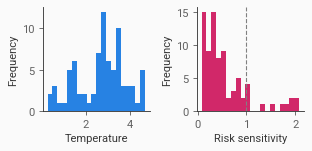

In [10]:
f, ax = plt.subplots(1, 2, figsize=(4, 2))

ax[0].hist(mean_estimated_params_A1[:, 0] * 5, bins=20, color=pal[0])  # rescale temperature to 0-5
ax[0].set_xlabel('Temperature')
ax[0].set_ylabel('Frequency')

ax[1].hist(mean_estimated_params_A1[:, 1] * 2.5, bins=20, color=pal[1]) # rescale risk sensitivity to 0-2.5
ax[1].set_xlabel('Risk sensitivity')
ax[1].set_ylabel('Frequency')
ax[1].axvline(1, color='gray', linestyle='--', linewidth=1)

sns.despine()

plt.tight_layout()

plt.savefig('figures/exp-3_cond-A1_estimated_params.svg')

In [40]:
mean_estimated_params_A1.shape

(80, 2)

In [52]:
from scipy.stats import ttest_1samp
t, p = ttest_1samp(mean_estimated_params_A1[:, 0] * 5, 0)
print('Mean (SD) = {:.2f} ({:.2f})'.format(mean_estimated_params_A1[:, 0].mean() * 5, mean_estimated_params_A1[:, 0].std() * 5))
print('t(79)={:.2f}, p={:.3f}'.format(t, p))

Mean (SD) = 2.71 (1.08)
t(79)=22.26, p=0.000


In [55]:
from scipy.stats import ttest_1samp
t, p = ttest_1samp(mean_estimated_params_A1[:, 1] * 2.5, 1)
print('Mean (SD) = {:.2f} ({:.2f})'.format(mean_estimated_params_A1[:, 1].mean() * 2.5, mean_estimated_params_A1[:, 1].std() * 2.5))
print('t(79)={:.2f}, p={:.3f}'.format(t, p))

Mean (SD) = 0.56 (0.49)
t(79)=-8.00, p=0.000


## Correlate with time spent in rich reward zones

In [11]:
time_in_rich_rewards = pd.read_csv('data/exp-3_time_in_rich_rewards.csv')
time_in_rich_rewards_A1 = time_in_rich_rewards[time_in_rich_rewards['condition'] == 'A1'].copy()

time_in_rich_rewards_A1['temperature'] = mean_estimated_params_A1[:, 0] * 5
time_in_rich_rewards_A1['risk_sensitivity'] = mean_estimated_params_A1[:, 1] * 2.5

In [12]:
# fit a Bayesian GLM using bambi
import bambi
import arviz as az

# Fit model
model_A1 = bambi.Model(data=time_in_rich_rewards_A1, formula='count_norm ~ temperature + risk_sensitivity')

# Sample from posterior
posterior_A1 = model_A1.fit(chains=4)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [13]:
summary_A1 = az.summary(posterior_A1, hdi_prob=0.95, round_to=2)
summary_A1

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.82,0.06,0.71,0.95,0.0,0.0,5071.31,3331.93,1.0
temperature,-0.03,0.02,-0.06,0.01,0.0,0.0,4793.25,3068.11,1.0
risk_sensitivity,-0.43,0.04,-0.50,-0.35,0.0,0.0,6062.23,3447.83,1.0
count_norm_sigma,0.17,0.01,0.15,0.20,0.0,0.0,5028.68,2833.98,1.0


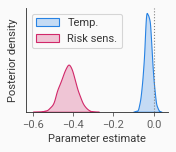

In [14]:
plt.figure(figsize=(2.3, 2))
sns.kdeplot(posterior_A1.posterior['temperature'].values.flatten(), fill=True, label='Temp.')
sns.kdeplot(posterior_A1.posterior['risk_sensitivity'].values.flatten(), fill=True, label='Risk sens.')
plt.axvline(0, color='gray', linestyle=':')
plt.xlabel('Parameter estimate')
plt.ylabel('Posterior density')
plt.yticks([])

plt.legend()

sns.despine()
plt.tight_layout()


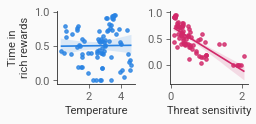

In [67]:
f, ax = plt.subplots(1, 2, figsize=(3.3, 1.65))

# plot regressions
sns.regplot(x='temperature', y='count_norm', data=time_in_rich_rewards_A1, ax=ax[0], color=pal[0], scatter_kws={'s': 10})
sns.regplot(x='risk_sensitivity', y='count_norm', data=time_in_rich_rewards_A1, ax=ax[1], color=pal[1], scatter_kws={'s': 10})

ax[0].set_xlabel('Temperature')
ax[0].set_ylabel('Time in\nrich rewards')

ax[1].set_xlabel('Threat sensitivity')
ax[1].set_ylabel('')

sns.despine()

plt.tight_layout()

plt.savefig('figures/exp-3_regression_param_plot.svg')
plt.savefig('figures/exp-3_regression_param_plot.pdf')

## Repeat for Condition A2

In [16]:
simulations_A2 = np.load('data/SBI_simulations/experiment-3/condition-A2/y_data.npy', allow_pickle=True).astype(float)
parameters_A2 = np.load('data/SBI_simulations/experiment-3/condition-A2/x_data.npy', allow_pickle=True).astype(float)
simulations_A2 = simulations_A2.reshape(simulations_A2.shape[0], 1, -1)
simulations_A2.shape

(20000, 1, 80)

In [17]:
train_size = int(train_prop * simulations_A2.shape[0])

train_simulations_A2 = simulations_A2[:train_size]
train_parameters_A2 = parameters_A2[:train_size]

test_simulations_A2 = simulations_A2[train_size:]
test_parameters_A2 = parameters_A2[train_size:]

print(train_simulations_A2.shape, test_simulations_A2.shape)

(19800, 1, 80) (200, 1, 80)


In [18]:
npe = NPEModel(choice_format='numerical')
npe.fit(train_simulations_A2, train_parameters_A2)

 Neural network successfully converged after 32 epochs.

In [19]:
sampled_params_A2 = npe.sample(test_simulations_A2, n_samples=2000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 84.26it/s]


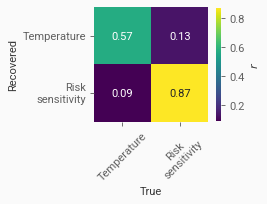

In [20]:
plot_recovery_matrix(
    test_parameters_A2.squeeze().astype(float), 
    sampled_params_A2, 
    param_names = ['Temperature', 'Risk\nsensitivity'], 
    scale=1.1, 
    xtick_rotation=45, 
    colorbar_scale=0.78, 
    save_path='figures/', 
    save_fname='exp-3_cond-A2_recovery.svg'
)

In [21]:
# Select condition A1
response_df_A2 = response_df[response_df['condition'] == 'A2'].copy()

# Initialise array to store all moves, with -1 as a placeholder for missing moves
all_moves_A2 = np.ones((response_df_A2['subjectID'].nunique(), 5, 16)) * -1

for n_sub, sub in enumerate(response_df_A2['subjectID'].unique()):

    for n_env, env in enumerate(response_df_A2['env'].unique()[1:]):

        # Get data for this subject and environment
        env_df = response_df_A2[(response_df_A2['subjectID'] == sub) & (response_df_A2['env'] == env)] 

        # Get prey moves for first 2 turns
        prey_moves = env_df.loc[(env_df['agent'] == 'prey') & (env_df['trial'] < 2), 'cellID'].tolist()
        all_moves_A2[n_sub, n_env, :len(prey_moves)] = prey_moves

        # Get predator moves for first turn
        predator_moves = env_df.loc[(env_df['agent'] == 'predator') & (env_df['trial'] < 1), 'cellID'].tolist()
        all_moves_A2[n_sub, n_env, 8:8+len(predator_moves)] = predator_moves

all_moves_A2 = all_moves_A2.reshape(all_moves_A2.shape[0], 1, -1)



In [22]:
estimated_params_A2 = npe.sample(all_moves_A2, n_samples=2000)
mean_estimated_params_A2 = estimated_params_A2.mean(axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 84.37it/s]


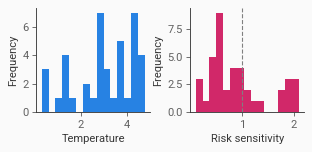

In [23]:
f, ax = plt.subplots(1, 2, figsize=(4, 2))

ax[0].hist(mean_estimated_params_A2[:, 0] * 5, bins=15, color=pal[0])  # rescale temperature to 0-5
ax[0].set_xlabel('Temperature')
ax[0].set_ylabel('Frequency')

ax[1].hist(mean_estimated_params_A2[:, 1] * 2.5, bins=15, color=pal[1]) # rescale risk sensitivity to 0-2.5
ax[1].set_xlabel('Risk sensitivity')
ax[1].set_ylabel('Frequency')
ax[1].axvline(1, color='gray', linestyle='--', linewidth=1)

sns.despine()

plt.tight_layout()

plt.savefig('figures/exp-3_cond-A2_estimated_params.svg')

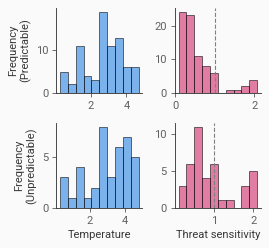

In [68]:
f, ax = plt.subplots(2, 2, figsize=(3.5, 3.2))

ax[0, 0].hist(mean_estimated_params_A1[:, 0] * 5, bins=10, color=pal[0], alpha=0.6, linewidth=.8, edgecolor='black')  # rescale temperature to 0-5
# ax[0, 0].set_xlabel('Temperature')
ax[0, 0].set_ylabel('Frequency\n(Predictable)')

ax[0, 1].hist(mean_estimated_params_A1[:, 1] * 2.5, bins=10, color=pal[1], alpha=0.6, linewidth=.8, edgecolor='black') # rescale risk sensitivity to 0-2.5
# ax[0, 1].set_xlabel('Risk sensitivity')
# ax[0, 1].set_ylabel('Frequency')
ax[0, 1].axvline(1, color='gray', linestyle='--', linewidth=1)

ax[1, 0].hist(mean_estimated_params_A2[:, 0] * 5, bins=10, color=pal[0], alpha=0.6, linewidth=.8, edgecolor='black')  # rescale temperature to 0-5
ax[1, 0].set_xlabel('Temperature')
ax[1, 0].set_ylabel('Frequency\n(Unpredictable)')

ax[1, 1].hist(mean_estimated_params_A2[:, 1] * 2.5, bins=10, color=pal[1], alpha=0.6, linewidth=.8, edgecolor='black') # rescale risk sensitivity to 0-2.5
ax[1, 1].set_xlabel('Threat sensitivity')
# ax[1, 1].set_ylabel('Frequency')
ax[1, 1].axvline(1, color='gray', linestyle='--', linewidth=1)


sns.despine()

plt.tight_layout()

plt.savefig('figures/exp-3_both_estimated_params.svg')
plt.savefig('figures/exp-3_both_estimated_params.pdf')

In [25]:
time_in_rich_rewards_A2 = time_in_rich_rewards[time_in_rich_rewards['condition'] == 'A2'].copy()

time_in_rich_rewards_A2['temperature'] = mean_estimated_params_A2[:, 0] * 5
time_in_rich_rewards_A2['risk_sensitivity'] = mean_estimated_params_A2[:, 1] * 2.5

In [26]:
# Fit model
model_A2 = bambi.Model(data=time_in_rich_rewards_A2, formula='count_norm ~ temperature + risk_sensitivity')

# Sample from posterior
posterior_A2 = model_A2.fit(chains=4)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [27]:
summary_A2 = az.summary(posterior_A2, hdi_prob=0.95, round_to=2)
summary_A2

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.61,0.08,0.46,0.77,0.0,0.0,4666.20,3299.74,1.0
temperature,-0.01,0.02,-0.05,0.03,0.0,0.0,5660.68,3250.72,1.0
risk_sensitivity,-0.33,0.04,-0.42,-0.25,0.0,0.0,4944.79,3446.08,1.0
count_norm_sigma,0.16,0.02,0.13,0.20,0.0,0.0,4014.48,3226.89,1.0


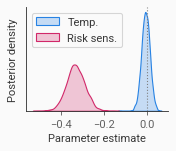

In [28]:
plt.figure(figsize=(2.3, 2))
sns.kdeplot(posterior_A2.posterior['temperature'].values.flatten(), fill=True, label='Temp.')
sns.kdeplot(posterior_A2.posterior['risk_sensitivity'].values.flatten(), fill=True, label='Risk sens.')
plt.axvline(0, color='gray', linestyle=':')
plt.xlabel('Parameter estimate')
plt.ylabel('Posterior density')
plt.yticks([])

plt.legend()

sns.despine()
plt.tight_layout()


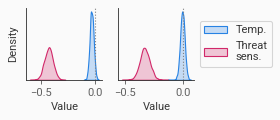

In [81]:
f, ax = plt.subplots(1, 2, figsize=(3.6, 1.6))

sns.kdeplot(posterior_A1.posterior['temperature'].values.flatten(), fill=True, label='Temp.', ax=ax[0])
sns.kdeplot(posterior_A1.posterior['risk_sensitivity'].values.flatten(), fill=True, label='Threat', ax=ax[0])
ax[0].axvline(0, color='gray', linestyle=':')
ax[0].set_xlabel('Value')
ax[0].set_ylabel('Density')
ax[0].set_yticks([])

sns.kdeplot(posterior_A2.posterior['temperature'].values.flatten(), fill=True, label='Temp.', ax=ax[1])
sns.kdeplot(posterior_A2.posterior['risk_sensitivity'].values.flatten(), fill=True, label='Threat\nsens.', ax=ax[1])
ax[1].axvline(0, color='gray', linestyle=':')
ax[1].set_xlabel('Value')
ax[1].set_ylabel('')
ax[1].set_yticks([])

# place legend to the right of the plot
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

sns.despine()

plt.tight_layout()

plt.savefig('figures/exp-3_both_regression_posteriors.svg')
plt.savefig('figures/exp-3_both_regression_posteriors.pdf')

In [38]:
print('Mean (SD) temp A1:', np.mean(mean_estimated_params_A1[:, 0] * 5), np.std(mean_estimated_params_A1[:, 0] * 5))
print('Mean (SD) temp A2:', np.mean(mean_estimated_params_A2[:, 0] * 5), np.std(mean_estimated_params_A2[:, 0] * 5))

print('Mean (SD) risk sens A1:', np.mean(mean_estimated_params_A1[:, 1] * 2.5), np.std(mean_estimated_params_A1[:, 1] * 2.5))
print('Mean (SD) risk sens A2:', np.mean(mean_estimated_params_A2[:, 1] * 2.5), np.std(mean_estimated_params_A2[:, 1] * 2.5))

t_temp, p_temp = ttest_ind(mean_estimated_params_A1[:, 0] * 5, mean_estimated_params_A2[:, 0] * 5)
t_risk, p_risk = ttest_ind(mean_estimated_params_A1[:, 1] * 2.5, mean_estimated_params_A2[:, 1] * 2.5)

print('t_temp:', t_temp, len(mean_estimated_params_A1[:, 0] * 5) + len(mean_estimated_params_A2[:, 0] * 5) - 2)
print('p_temp:', p_temp)

print('t_risk:', t_risk, len(mean_estimated_params_A1[:, 0] * 5) + len(mean_estimated_params_A2[:, 0] * 5) - 2)
print('p_risk:', p_risk)

Mean (SD) temp A1: 2.7128785 1.083093
Mean (SD) temp A2: 3.026635 1.2730187
Mean (SD) risk sens A1: 0.5619072 0.48686302
Mean (SD) risk sens A2: 0.932932 0.5778193
t_temp: -1.3972374513424572 118
p_temp: 0.1649639883652308
t_risk: -3.6610622558946724 118
p_risk: 0.00037715802447310084
